CREA DATA DE UN RESTAURANTE DESDE ENERO 2022 HASTA DICIEMBRE 2024, GENERA TAMBIEN DATAS DE VENTAS SEGUN LOS PLATOS(MAXIMO 1500 PLATOS), SON LOS SIGUIENTES: CHICHARRON DE POLLO, CUY CHACTADO, ARROZ VERDE DE PATO, PICANTE. EVALUAR FECHAS FESTIVAS, EN ESTE CASO SOLO DICIEMBRE Y ENERO EN DONDE LAS VENTAS SE TRIPLICAN ENTREGAR UN DATAFRAME QUE CONTENGA LA PREDICCION DE LAS VENTAS DESDE ENERO 2025 HASTA DICIEMBRE 2025, Y TAMBIEN EL PLATO EN EL QUE SE DEBE INVERTIR POR CADA MES

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


<ipython-input-11-ae2e4623fffe>:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas_2025 = pd.date_range(start='2025-01-01', end='2025-12-31', freq='M')
<ipython-input-11-ae2e4623fffe>:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prediccion_agrupada = prediccion_df.groupby(['Año', 'Mes']).apply(seleccionar_mejor_plato).reset_index(drop=True)


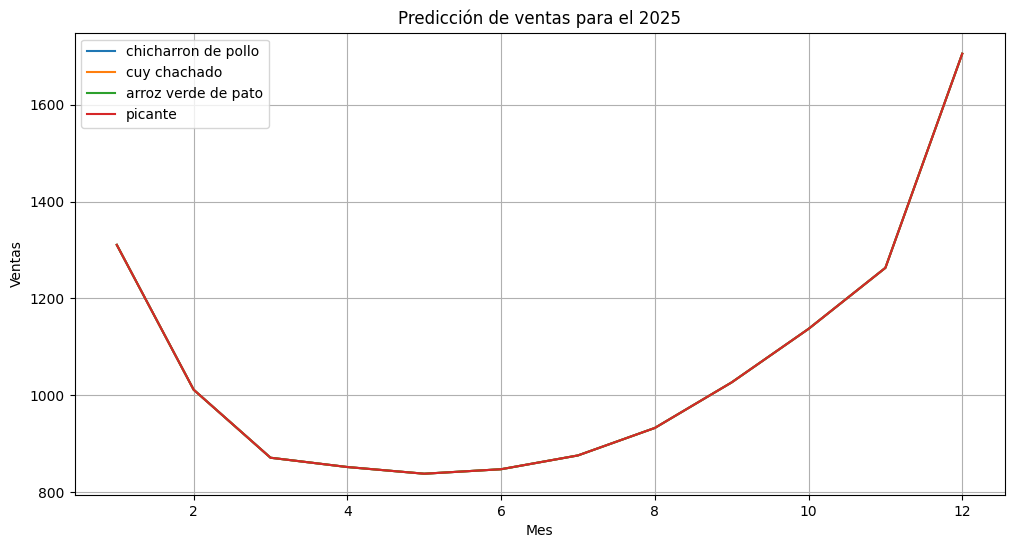

Predicciones de ventas y plato de mayor inversión por mes para el 2025:
     Año  Mes                Plato  Ventas_pred
0   2025    1  chicharron de pollo  1310.475220
1   2025    2  chicharron de pollo  1011.189697
2   2025    3              picante   870.654968
3   2025    4  arroz verde de pato   851.435303
4   2025    5  arroz verde de pato   837.611328
5   2025    6              picante   846.895569
6   2025    7         cuy chachado   875.408752
7   2025    8  chicharron de pollo   932.190613
8   2025    9         cuy chachado  1026.359375
9   2025   10         cuy chachado  1136.919556
10  2025   11  arroz verde de pato  1263.055054
11  2025   12  arroz verde de pato  1705.484985


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2

# Generar los datos de enero 2022 hasta diciembre 2024
np.random.seed(42)
fechas = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
platos = ['chicharron de pollo', 'cuy chachado', 'arroz verde de pato', 'picante']

# Generar datos
data = []
for fecha in fechas:
    for plato in platos:
        ventas = np.random.randint(10, 50)  # Ventas diarias base
        if fecha.month in [12, 1]:  # Ventas triplicadas para diciembre y enero
            ventas *= 3

        # Sesgos aleatorios por plato
        if plato == 'chicharron de pollo':
            ventas += np.random.randint(0, 5)
        elif plato == 'cuy chachado':
            ventas += np.random.randint(-2, 3)
        elif plato == 'arroz verde de pato':
            ventas += np.random.randint(-1, 4)
        elif plato == 'picante':
            ventas += np.random.randint(-3, 5)

        data.append([fecha, plato, ventas])

# Crear DataFrame
df = pd.DataFrame(data, columns=['Fecha', 'Plato', 'Ventas'])
df['Mes'] = df['Fecha'].dt.month
df['Año'] = df['Fecha'].dt.year

# Agrupar por mes y plato
ventas_mensuales = df.groupby(['Año', 'Mes', 'Plato'])['Ventas'].sum().reset_index()

# Variables independientes y dependiente
X = ventas_mensuales[['Año', 'Mes']]
y = ventas_mensuales['Ventas']

# Escalar los datos
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Crear modelo de red neuronal
model = Sequential([
    Dense(32, input_dim=X_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='linear')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_scaled, y_scaled, epochs=50, batch_size=10, verbose=0)

# Generar predicciones para 2025
fechas_2025 = pd.date_range(start='2025-01-01', end='2025-12-31', freq='M')
prediccion_data = []

for fecha in fechas_2025:
    for plato in platos:
        prediccion_data.append([fecha.year, fecha.month, plato])

prediccion_df = pd.DataFrame(prediccion_data, columns=['Año', 'Mes', 'Plato'])

# Escalar los datos para predicción
X_pred = prediccion_df[['Año', 'Mes']]
X_pred_scaled = scaler_X.transform(X_pred)
y_pred_scaled = model.predict(X_pred_scaled)

# Desescalar las predicciones
prediccion_df['Ventas_pred'] = scaler_y.inverse_transform(y_pred_scaled)

# Función para seleccionar el mejor plato
def seleccionar_mejor_plato(grupo):
    umbral = 50
    max_ventas = grupo['Ventas_pred'].max()
    candidatos = grupo[grupo['Ventas_pred'] >= max_ventas - umbral]
    return candidatos.sample(1)

# Selección del mejor plato por mes
prediccion_agrupada = prediccion_df.groupby(['Año', 'Mes']).apply(seleccionar_mejor_plato).reset_index(drop=True)

# Graficar las predicciones
plt.figure(figsize=(12, 6))
for plato in platos:
    plato_data = prediccion_df[prediccion_df['Plato'] == plato]
    plt.plot(
        plato_data['Mes'] + (plato_data['Año'] - 2025) * 12,
        plato_data['Ventas_pred'],
        label=plato
    )
plt.title('Predicción de ventas para el 2025')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.legend()
plt.grid()
plt.show()

# Mostrar las predicciones agrupadas
print("Predicciones de ventas y plato de mayor inversión por mes para el 2025:")
print(prediccion_agrupada[['Año', 'Mes', 'Plato', 'Ventas_pred']])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2280 - loss: 1.4532 - val_accuracy: 0.1750 - val_loss: 1.5044
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2387 - loss: 1.4452 - val_accuracy: 0.2250 - val_loss: 1.4789
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2552 - loss: 1.4205 - val_accuracy: 0.2250 - val_loss: 1.4584
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2851 - loss: 1.4155 - val_accuracy: 0.2250 - val_loss: 1.4426
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2534 - loss: 1.4016 - val_accuracy: 0.2000 - val_loss: 1.4325
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3078 - loss: 1.3823 - val_accuracy: 0.2500 - val_loss: 1.4223
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2728 - loss: 1.3976 - val_accuracy: 0.2250 - val_loss: 1.4150
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3420 - loss: 1.3867 - val_accuracy: 0.2250 - val_loss

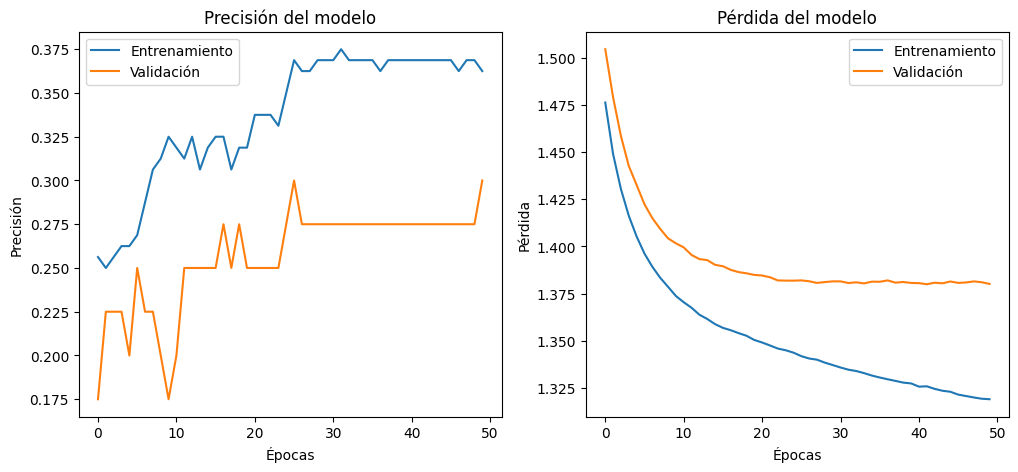

In [ ]:
#EJERCICIO 01

# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Generar datos simulados para el restaurante
np.random.seed(42)
# Datos del restaurante
platos = ['Ceviche', 'Lomo Saltado', 'Aji de Gallina', 'Pollo a la Brasa']
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
data = {
 'DiaSemana': np.random.choice(dias_semana, 200),
 'Clientes': np.random.randint(10, 100, 200),
 'PromocionActual': np.random.choice([0, 1], 200), # 0: Sin promoción, 1: Con promoción
 'Plato': np.random.choice(platos, 200)
}
df = pd.DataFrame(data)
# Generar variable objetivo (Ventas Simuladas)
df['Ventas'] = df['Clientes'] * (np.random.uniform(0.8, 1.2, 200)) + df['PromocionActual'] * 10
# Codificar variables categóricas
label_encoder_dia = LabelEncoder()
df['DiaSemana'] = label_encoder_dia.fit_transform(df['DiaSemana'])
label_encoder_plato = LabelEncoder()
df['Plato'] = label_encoder_plato.fit_transform(df['Plato'])
# Dividir en características y variable objetivo
X = df[['DiaSemana', 'Clientes', 'PromocionActual']]
y = df['Plato']
# Normalizar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Crear el modelo de red neuronal
model = Sequential([
 Dense(16, input_dim=X_train.shape[1], activation='relu'),
 Dense(8, activation='relu'),
 Dense(4, activation='softmax') # 4 salidas porque hay 4 platos
])
# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss:.4f}, Precisión: {accuracy:.4f}")

# Hacer predicciones
predicciones = model.predict(X_test)
predicciones_clases = np.argmax(predicciones, axis=1)

# Mostrar resultados
resultados = pd.DataFrame({
 'Real': label_encoder_plato.inverse_transform(y_test),
 'Predicción': label_encoder_plato.inverse_transform(predicciones_clases)
})
print(resultados.head())

# Gráficas de desempeño
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Precisión del entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
# Pérdida del entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
#LABELENCODER

'''
['Zapatos', 'Pelota', 'Chompa', 'Polera']

Asignacion
Zapatos = 0
Pelota = 1
Chompa = 2
Polera = 3

'''

import sklearn
from sklearn.preprocessing import LabelEncoder
#datos categoricos
datos = ['Zapatos','Pelota','Chompa','Polera']
#crear un obj LabelEncoder
label_encoder = LabelEncoder()
#transformar los datos
datos_numericos = label_encoder.fit_transform(datos)
print(datos)
print(datos_numericos)

['Zapatos', 'Pelota', 'Chompa', 'Polera']
[3 1 0 2]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Generar datos simulados para la reserva de hotel
np.random.seed(42)

# Datos del restaurante
tipo_hab = ['Simple', 'Doble', 'Matrimonial', 'Suite']
epoca_año = ['Otoño','Verano','Primavera','Invierno']

data = {
 'NroNoches': np.random.randint(1, 15, 500),
 'TipoHabitaciones': np.random.choice(tipo_hab, 500),
 'Epocas': np.random.choice(epoca_año, 500),
 'Desayuno': np.random.choice([0, 1], 500), # 0: Sin desayuno, 1: Con desayuno
 'ReservaCancelada': np.random.choice([0, 1], 500) # 0: No cancelada, 1: Cancelada
}

df = pd.DataFrame(data)
# transformar variables categoricas
label_encoder_tipo_hab = LabelEncoder()
df['TipoHabitaciones'] = label_encoder_tipo_hab.fit_transform(df['TipoHabitaciones'])

label_encoder_epoca = LabelEncoder()
df['Epocas'] = label_encoder_epoca.fit_transform(df['Epocas'])

#separar en X and y
X = df[['NroNoches', 'TipoHabitaciones', 'Epocas', 'Desayuno']]
y = df['ReservaCancelada']

#normalizacion
scaler = StandardScaler()
X = scaler.fit_transform(X)
#para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#creamos el modelo de red neuronal
model = Sequential([
 Dense(16, input_dim=X_train.shape[1], activation='relu'),
 Dense(8, activation='relu'),
 Dense(1, activation='sigmoid') #salida binaria 0 y 1
])
#compilar
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#entrenar
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_train, y_test), verbose=0)
#evaluar la perdida
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss:.4f}, Precisión: {accuracy:.4f}")

# Hacer predicciones
predicciones = model.predict(X_test)
predicciones_class = np.argmax(predicciones,axis=1)

# Mostrar resultados
df_resultados = pd.DataFrame({ 'Real': y_test,
                               'Predicción': predicciones_clases})
print(df_resultados)



# Gráficas de desempeño
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Precisión del entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
# Pérdida del entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4913 - loss: 0.7056  
Pérdida: 0.7172, Precisión: 0.4600


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4605 - loss: 0.7028  
Pérdida: 0.7130, Precisión: 0.4300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
   Real  Predicción
0     0           1
1     0           1
2     1           0
3     0           1
4     0           0


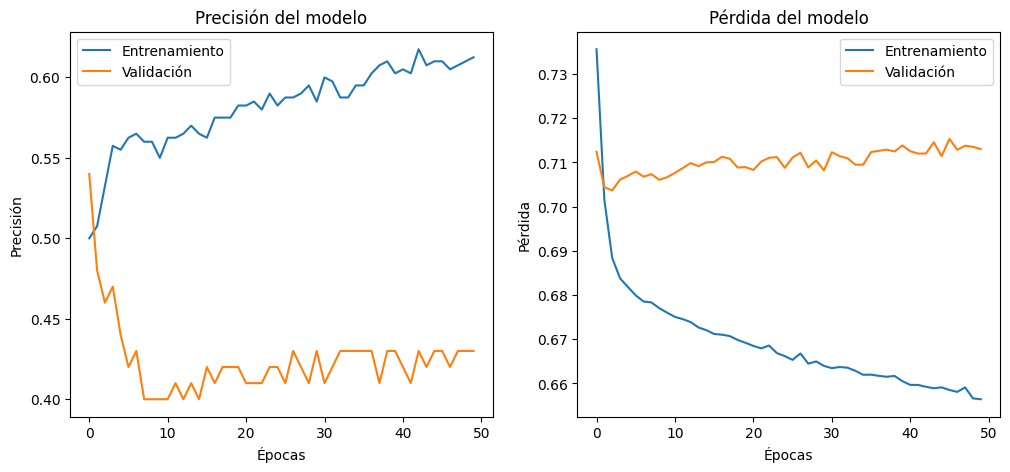